In [4]:
%reload_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
from matplotlib.ticker import FormatStrFormatter

sys.path.insert(0, './pynbody_root')
from pynbody import Body, NBodySimulation
from pynbody import plot_utils as pu

Set N massless particles uniformly distributed in a disk and circularly orbiting a mass $m$ 

In [5]:
N = 10000
rs = np.random.uniform(0.2, 1, N)
phis = np.random.uniform(0, 2*np.pi, N)
zs = np.random.uniform(-0.0, 0.00, N)

m = 1
l = np.array([0,0,1])
periods = []
bodies = []
for r, phi, z in zip(rs, phis, zs):
    pos = np.array([r*np.cos(phi), r*np.sin(phi), z])
    vel = np.cross(l, pos)
    vel /= np.linalg.norm(vel)
    v_mag = 1*np.sqrt(m/r)
    vel = v_mag*vel
    bodies.append(Body(0, 
                       pos,
                       vel))
    
    periods.append(2*np.pi*r / v_mag)
    
body_m = Body(m, (0,0,0), (0,0,0))
body_list = [body_m] + bodies

T_min, T_max = np.min(periods), np.max(periods)
print(f'Min period: {T_min:.2f} s')
print(f'Max period: {T_max:.2f} s')

Min period: 0.56 s
Max period: 6.28 s


Choose the integrators: 'euler' and leapfrog', defined in the integrators.py file and utilized in the NBodySimulation class.

Integrate the 2-body orbits. 

Save each frame using the save_video() method in the NBodySimulation class. 

In [7]:
T = 1*T_max
dt = T_min / 10
print(f'Total time: {T:.2f} s')
print(f'Timestep: {dt:.2f} s')

integrators = ['euler', 'leapfrog']
energies = {integrator: None for integrator in integrators}
for integrator in integrators:

    sim = NBodySimulation(body_list)
    sim.integrator = integrator
    sim.run_simulation(T, dt)
    pos_arr = sim.positions
    vel_arr = sim.velocities

    # Compute specific energies
    K = 0.5*np.sum(np.linalg.norm(vel_arr[:,:,1:], axis=1), axis=1)
    U = -np.sum(1/np.linalg.norm(pos_arr[:,:,1:], axis=1), axis=1)
    E = K + U

    energies[integrator] = E

    # save frames and video for each
    save_fold = f'figures/{integrator}/pngs/'
    make_plots = True
    sim.save_video(save_fold, elev=20, scatter_size=1.85, frames='all', fps=20, fig_size=1080,
                make_plots=make_plots)

Total time: 6.28 s
Timestep: 0.06 s
99.10%

Make plot using the already rendered figures and adding energy

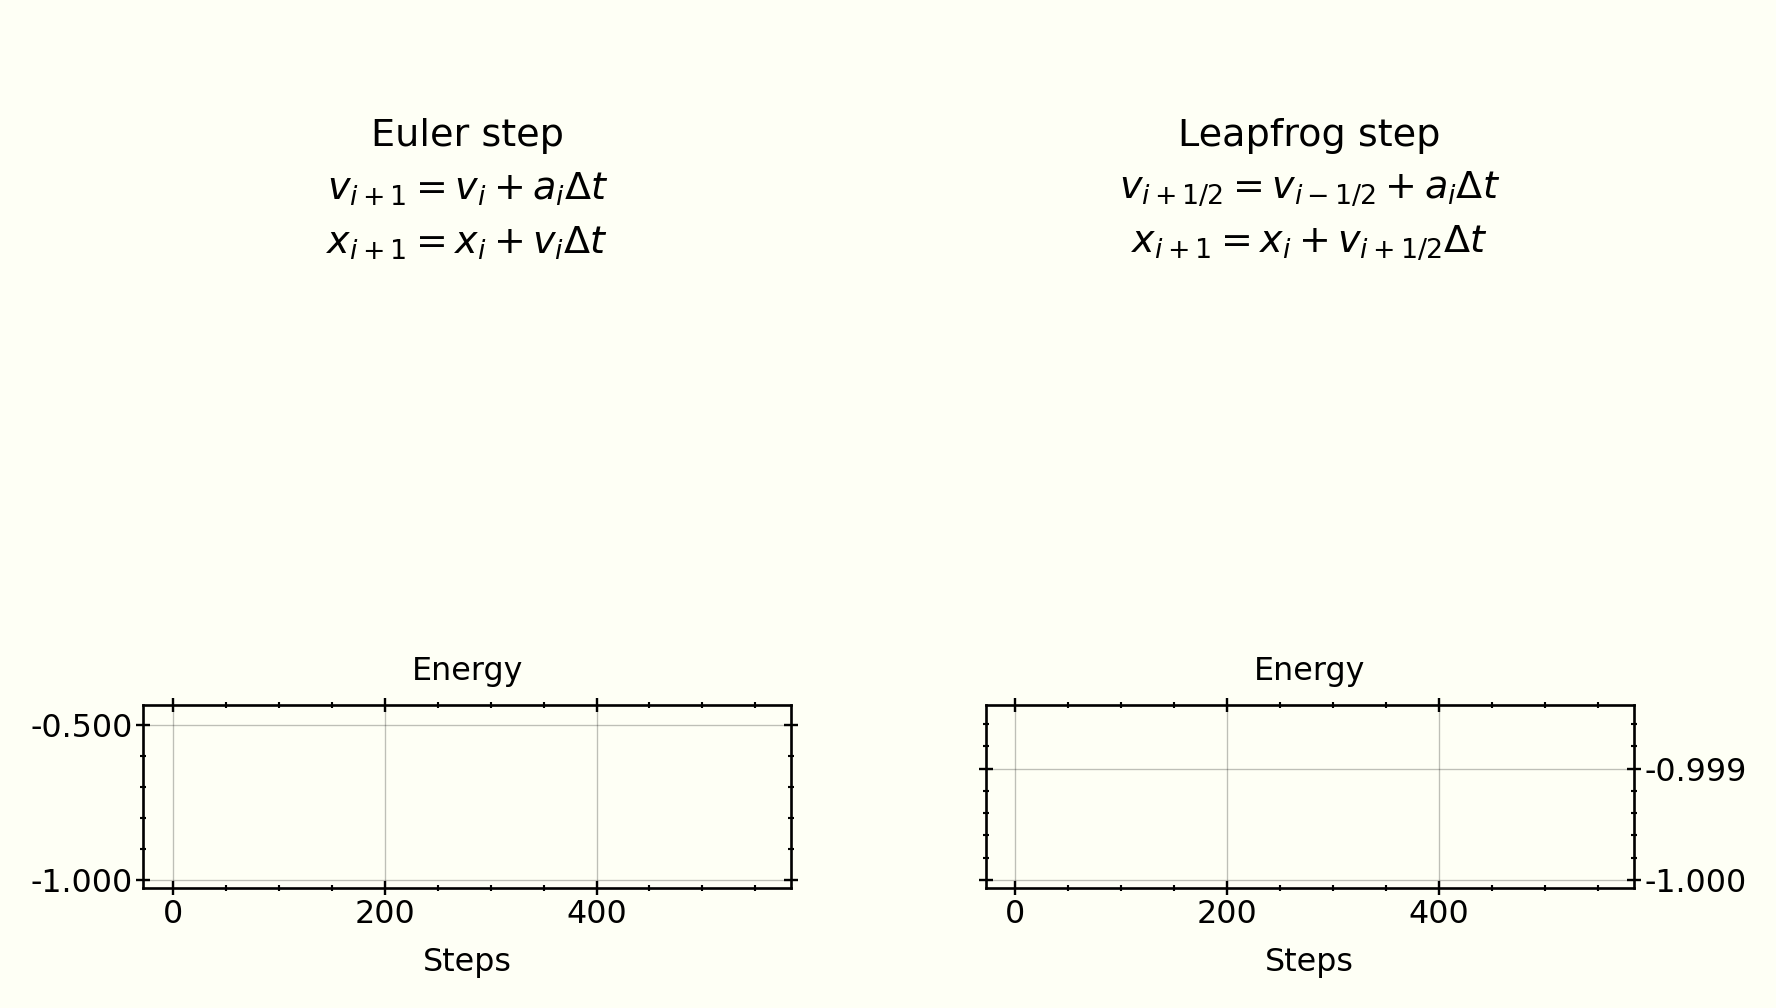

In [255]:
# Normalize energy to -1
energy0 = energies['euler'][0]
for integrator in integrators:
    energies[integrator] /= np.abs(energy0)

# create figure
subplots = (1,2)
ts=1.5
Fig = pu.Figure(subplots=subplots, ts=ts, theme='default', wspace=-0.01, sw=0.125, fig_size=1080)
fig = Fig.fig
axes = Fig.axes_flat
fs = Fig.fs

# get the rendered images for each integrator
folds = ['figures/' + integrator + '/pngs/' for integrator in integrators]
files = {integrator: [fold + file for file in os.listdir(fold)] for integrator, fold in zip(integrators, folds)}

facecolor='#FEFFF5'
fig.patch.set_facecolor(facecolor)

# add new axes to figure
left0, left1 = 0.17, 0.56
bottom = 0.085
width = 0.3
height = 0.17
rect0 = [left0, bottom, width, height]
rect1 = [left1, bottom, width, height]

ax0 = fig.add_axes(rect0)
ax0 = Fig.customize_axes(ax0)
ax0.set_title('Energy', fontsize=fs*1.5, color='k')
ax0.set_xlabel('Steps', fontsize=fs*1.5, color='k')

ax1 = fig.add_axes(rect1)
ax1 = Fig.customize_axes(ax1, ylabel_pos='right')
ax1.set_title('Energy', fontsize=fs*1.5, color='k')
ax1.set_xlabel('Steps', fontsize=fs*1.5, color='k')

# Add text

tts = 1.8
dr = 0.05

text00 = 'Euler step'
text01 = r'$v_{i+1} = v_i +a_i \Delta t$'
text02 = r'$x_{i+1} = x_i + v_{i} \Delta t$'
fig.text(left0+width/2, bottom+4*height, text00, ha='center', va='bottom', fontsize=fs*tts, color='k')
fig.text(left0+width/2, bottom+4*height-dr, text01, ha='center', va='bottom', fontsize=fs*tts, color='k')
fig.text(left0+width/2, bottom+4*height-2*dr, text02, ha='center', va='bottom', fontsize=fs*tts, color='k')

text10 = 'Leapfrog step'
text11 = r'$v_{i+1/2} = v_{i-1/2} +a_i \Delta t$'
text12 = r'$x_{i+1} = x_i + v_{i+1/2} \Delta t$'
fig.text(left1+width/2, bottom+4*height, text10, ha='center', va='bottom', fontsize=fs*tts, color='k')
fig.text(left1+width/2, bottom+4*height-dr, text11, ha='center', va='bottom', fontsize=fs*tts, color='k')
fig.text(left1+width/2, bottom+4*height-2*dr, text12, ha='center', va='bottom', fontsize=fs*tts, color='k')

# Some formatting of axes
for ax in [ax0, ax1]:
    ax.set_facecolor(facecolor)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

for ax in axes:
    ax.set_facecolor(facecolor)
    ax.axis('off')

# Cropping parameters of figure
fig_size = Fig.fig_size
dpi = Fig.dpi
ratio = Fig.ratio
inch_size = fig_size/dpi
sc = 0.1*inch_size
sh_x = 0.103*inch_size
sh_y = -0.1105*inch_size

x0, y0 = sc + sh_x, sc + sh_y
x1, y1 = inch_size*ratio*0.93 - sc + sh_x, inch_size*1.05 - sc + sh_y

savefold = 'figures/euler_leapfrog/pngs/'
if not os.path.exists(savefold):
    os.makedirs(savefold)

lw = 0.4
for i in range(len(files['euler'])):
    img0 = Image.open(files['euler'][i])
    pim0 = axes[0].imshow(img0)
    img1 = Image.open(files['leapfrog'][i])
    pim1 = axes[1].imshow(img1)
    p1 = ax0.plot(energies['euler'][:i], color='k', lw=lw*fs)
    p2 = ax1.plot(energies['leapfrog'][:i], color='k', lw=lw*fs)

    savefile = savefold + f'render_{i:04d}.png'

    fig.savefig(savefile, dpi=300, facecolor=facecolor, 
                bbox_inches=mpl.transforms.Bbox([[x0, y0], [x1, y1]]))

    # remove 
    pim0.remove()
    pim1.remove()
    p1[0].remove()
    p2[0].remove()

    plt.close()

In [257]:
savefold

'figures/euler_leapfrog/pngs/'

In [260]:
pu.png_to_mp4(savefold, fps=60, extension='.png')

In [253]:
p1